In [36]:
import pandas as pd

dm1 = pd.read_csv('../data/external/demographics/dem_fullpilot12.csv')
dm2 = pd.read_csv('../data/external/demographics/dem_fullpilot13.csv')
dm3 = pd.read_csv('../data/external/demographics/dem_fullpilot14.csv')



df1 = pd.read_csv('../data/raw/fullpilot13_2.csv')
df2 = pd.read_csv('../data/raw/fullpilot1466.csv')


df2 = df2[df2.expName.isin(['FullPilot14'])]
df1 = df1[df1.expName.isin(['FullPilot13', 'FullPilot12'])]

df1 = df1.groupby('prolificID').filter(lambda x: len(x) >= 483)
df2 = df2.groupby('prolificID').filter(lambda x: len(x) >= 483)
# df = df.groupby('prolificID').filter(lambda x: len(x) <= 432)
# keep  prolificIDs that are more than 10 characters
df1 = df1[df1.prolificID.str.len() > 10]
df2 = df2[df2.prolificID.str.len() > 10]
# show prolificIDs 

In [ ]:
dm1['prolificID'] = dm1['Participant id']
dm2['prolificID'] = dm2['Participant id']
dm3['prolificID'] = dm3['Participant id']

In [ ]:
pids1 = df1.prolificID.unique()
pids2 = df2.prolificID.unique()

# check that pids1 are in dm1 and pids2 are in dm2
dm1 = dm1[(dm1.prolificID.isin(pids1)) | (dm1.prolificID.isin(pids2))]
dm2 = dm2[(dm2.prolificID.isin(pids1)) | (dm2.prolificID.isin(pids2))]
dm3 = dm3[(dm3.prolificID.isin(pids1)) | (dm3.prolificID.isin(pids2))]

In [ ]:
# check dm1 and dm2 do not have the same prolificIDs
dm1 = dm1[~dm1.prolificID.isin(dm2.prolificID)]
dm2 = dm2[~dm2.prolificID.isin(dm1.prolificID)]
dm3 = dm3[~dm3.prolificID.isin(dm1.prolificID)]
dm3 = dm3[~dm3.prolificID.isin(dm2.prolificID)]


In [63]:
np.unique(np.array([df.p1, df.p2]).flatten())[:-1]

array([0.12, 0.18, 0.27, 0.38, 0.5 , 0.62, 0.73, 0.82, 0.88])

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_csv('../data/raw/fullpilot1466.csv')
df2 = pd.read_csv('../data/raw/fullpilot13_22.csv')
df3 = pd.read_csv('../data/raw/test/spaceprl(26).csv')

df = df[df.expName.isin(['FullPilot12', 'FullPilot13', 'FullPilot14', ])]
df2 = df2[df2.expName.isin(['FullPilot12', 'FullPilot13'])]
df3 = df3[df3.expName.isin(['FullPilot12_2'])]
#concat df and df3
df = pd.concat([df, df3])

df = df.groupby('prolificID').filter(lambda x: len(x) >= 483)
df2 = df2.groupby('prolificID').filter(lambda x: len(x) >= 483)

df = pd.concat([df, df2])
# df = df.groupby('prolificID').filter(lambda x: len(x) <= 432)
# keep  prolificIDs that are more than 10 characters
df = df[df.prolificID.str.len() > 10]
# show prolificIDs

expName = ['FullPilot12_2',  'FullPilot12', 'FullPilot13', 'FullPilot14']

df['opti_ss'] = ((df.m1 > df.m2) & (df.choice==1)) | ((df.m1 < df.m2) & (df.choice==2))
df['opti_ff'] = ((df.p1 > df.p2) & (df.choice==1)) | ((df.p1 < df.p2) & (df.choice==2))
df['opti_ev'] = ((df.ev1 > df.ev2) & (df.choice==1)) | ((df.ev1 < df.ev2) & (df.choice==2))

df = df[df.expName.isin(expName)]

# remove duplicates and only take first based on prolificID, t, session
df = df.drop_duplicates(subset=['prolificID', 't', 'session'])


map_prolificID = {pid: i for i, pid in enumerate(df.prolificID.unique())}
df['id'] = df.prolificID.map(map_prolificID)

print(f'N = {len(df.prolificID.unique())}')


N = 245


In [59]:

session = 3
df_ = df[(df.session==session)].groupby(['prolificID'], as_index=False).mean(numeric_only=True)

import scipy.stats as stats

df_['delta'] = df_.opti_ff - df_.opti_ss

df_['opti_ff'] = df_.opti_ff.astype(float)
df_['opti_ss'] = df_.opti_ss.astype(float)
df_['delta'] = df_.delta.astype(float)
df['opti_ff'] = df['opti_ff'].astype(float)
df['opti_ss'] = df['opti_ss'].astype(float)
         
df2 = df[(df.session==session) & (df.expName.isin(expName))]

def get_group2(row):
    opti_ff = df2[df2.prolificID==row.prolificID].opti_ff
    opti_ss = df2[df2.prolificID==row.prolificID].opti_ss
    ttest = stats.ttest_rel(opti_ff, opti_ss)
    p = ttest.pvalue
    t = ttest.statistic
    p_ss = stats.ttest_1samp(opti_ss, 0.5, alternative='greater').pvalue < 0.05 
    p_ff = stats.ttest_1samp(opti_ff, 0.5, alternative='greater').pvalue < 0.05

    if p > 0.05:
        if p_ss and p_ff:
            return 'balanced'
        if p_ss:
            return 'value'
        if p_ff:
            return 'perceptual'
        return 'random'
    
    if t > 0 and p_ff:
        return 'perceptual'
    if t < 0  and p_ss:
        return 'value'

    return 'random'

def get_group(row):
    opti_ff = df2[df2.prolificID==row.prolificID].opti_ff
    opti_ss = df2[df2.prolificID==row.prolificID].opti_ss
    p_ss = stats.ttest_1samp(opti_ss, 0.5, alternative='greater').pvalue < 0.05 
    p_ff = stats.ttest_1samp(opti_ff, 0.5, alternative='greater').pvalue < 0.05

    if p_ss and p_ff:
        return 'combined'
        
    
    if p_ff:
        return 'perceptual'
    if p_ss:
        return 'value'

    return 'random'
    # raise ValueError('unexpected value')

df_['group'] = df_.apply(get_group, axis=1)

df['group'] = df['prolificID'].map(df_.set_index('prolificID')['group'])

# df = df[df.group != 'random']
print(len(df.prolificID.unique()))

245


In [41]:
import pandas as pd
from pathlib import Path

# Get all CSV files in the data/external directory
data_dir = Path('../data/external/demographics/')
csv_files = sorted(data_dir.glob('prolific_demographic_export_*.csv'))
print(f'Found {len(csv_files)} CSV files to merge.')
# Read and concatenate all CSV files
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    # Optional: add a column to track source file
    df['source_file'] = file.name
    dfs.append(df)

# Merge all dataframes
merged_df = pd.concat(dfs, ignore_index=True)

# Display info about the merged data
print(f"Total files merged: {len(csv_files)}")
print(f"Total rows: {len(merged_df)}")
print(f"Columns: {list(merged_df.columns)}")
print(f"\nFirst few rows:")
merged_df.head()

dm = merged_df.copy()
dm['prolificID'] = dm['Participant id']
print(f'N = {len(dm.prolificID.unique())}')

Found 11 CSV files to merge.
Total files merged: 11
Total rows: 665
Columns: ['Submission id', 'Participant id', 'Status', 'Custom study tncs accepted at', 'Started at', 'Completed at', 'Reviewed at', 'Archived at', 'Time taken', 'Completion code', 'Total approvals', 'Age', 'Sex', 'Ethnicity simplified', 'Country of birth', 'Country of residence', 'Nationality', 'Language', 'Student status', 'Employment status', 'source_file']

First few rows:
N = 628


In [20]:
dm.prolificID

0      5dd4767b32288646716dc98a
1      5cfb82a12bcca70018252f81
2      650ee274aa4447ac435b7830
3      63316daa57747115376760da
4      631c8e97db06f601f81bd82f
                 ...           
660    612bb0204ad8e7e8bed041eb
661    6637b21240220c2517fffa1a
662    6405feae7d6321bfaaf793e8
663    676276312d87ec9601be7d5c
664    675aaec58dfc729c338a52eb
Name: prolificID, Length: 665, dtype: object

In [42]:
# retrieve demographics for participants in df
dm_ = dm[dm.prolificID.isin(df.prolificID.unique())]
print(f'N = {len(dm_.prolificID.unique())}')

AttributeError: 'DataFrame' object has no attribute 'prolificID'

In [55]:
# now we check the columns in dm_ and see which ones we want to keep
dm2 = dm_[['Age', 'Sex', 'Nationality', 'prolificID']].drop_duplicates(subset=['prolificID'])
# coerce dm2 Age to numeric
dm2['Age'] = pd.to_numeric(dm2['Age'], errors='coerce')
# set expName from df (set expName based on df to prolificID), no merge
dm2['expName'] = dm2.apply(lambda row: df[df.prolificID == row.prolificID].expName.values[0], axis=1)

print(f'N = {len(dm2.prolificID.unique())}')

N = 245


DEMOGRAPHICS SUMMARY

Total Participants: 245

Age Statistics:
count    243.000000
mean      36.744856
std       11.801769
min       18.000000
25%       28.000000
50%       35.000000
75%       45.000000
max       73.000000
Name: Age, dtype: float64

Sex Distribution:
Sex
Male               123
Female             120
CONSENT_REVOKED      2
Name: count, dtype: int64

Sex
Male               50.204082
Female             48.979592
CONSENT_REVOKED     0.816327
Name: proportion, dtype: float64

Top 10 Nationalities:
Nationality
United States         218
Nigeria                 7
Ghana                   2
CONSENT_REVOKED         2
DATA_EXPIRED            2
Philippines             2
Canada                  1
Dominican Republic      1
Vietnam                 1
Mexico                  1
Name: count, dtype: int64

Experiment Distribution:
expName
FullPilot14      65
FullPilot13      64
FullPilot12      61
FullPilot12_2    55
Name: count, dtype: int64

Random Choice Classification by Experiment:
Fu

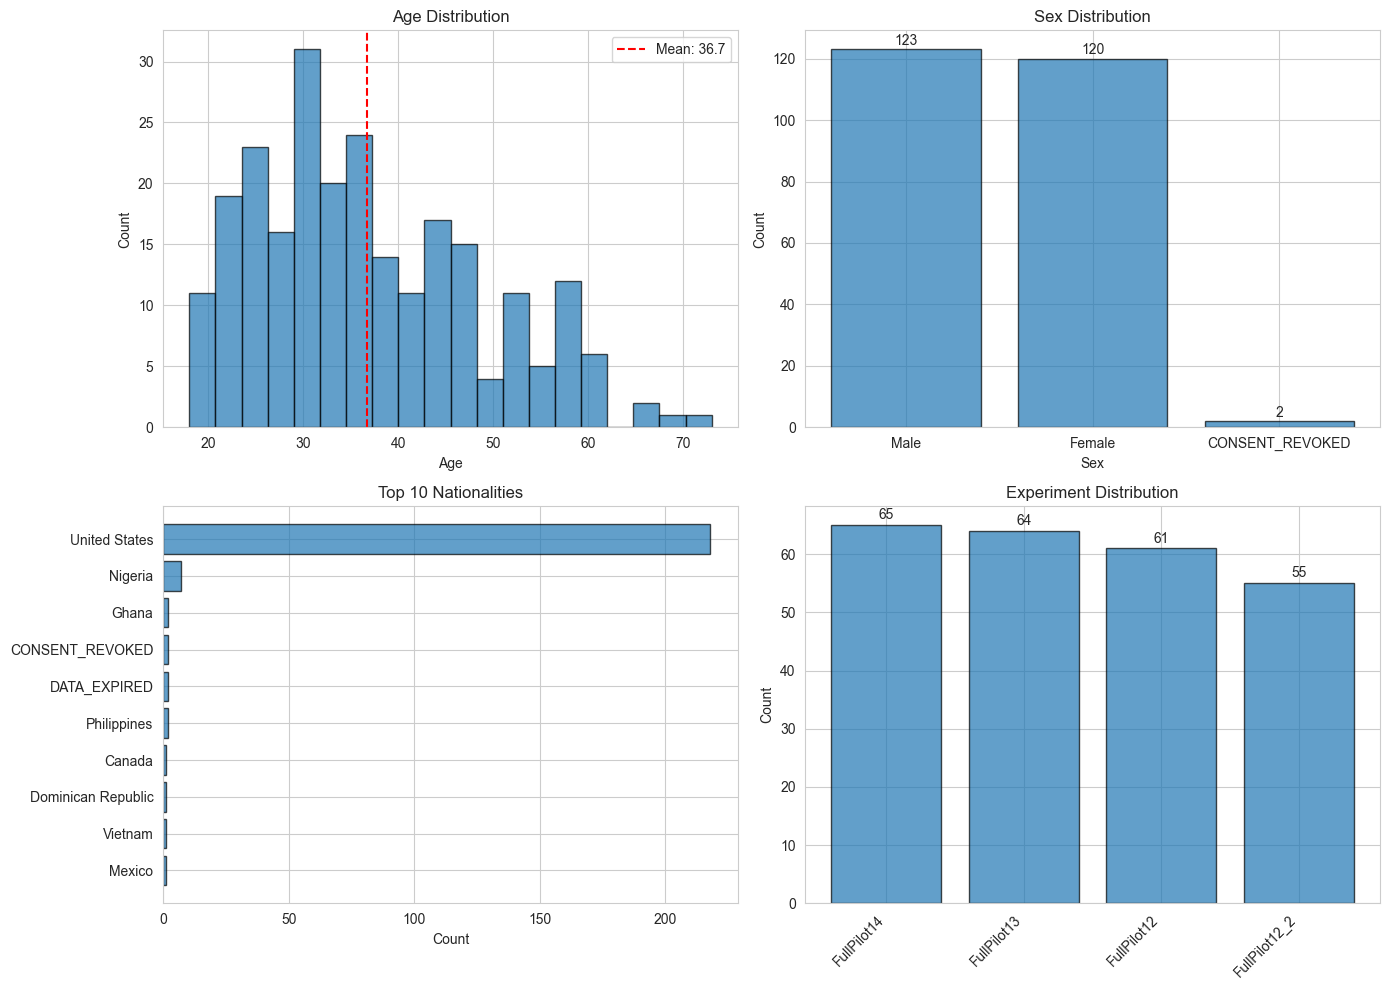


AGE BY SEX
                 count       mean        std   min    25%   50%    75%   max
Sex                                                                         
CONSENT_REVOKED    0.0        NaN        NaN   NaN    NaN   NaN    NaN   NaN
Female           120.0  38.116667  12.639928  20.0  28.75  35.5  46.25  73.0
Male             123.0  35.406504  10.806675  18.0  27.00  34.0  44.00  60.0

AGE BY EXPERIMENT
               count       mean        std   min    25%   50%    75%   max
expName                                                                   
FullPilot12     61.0  36.475410  12.332351  18.0  29.00  34.0  45.00  73.0
FullPilot12_2   55.0  42.745455  11.830936  24.0  33.50  39.0  52.50  68.0
FullPilot13     62.0  35.129032  10.846899  19.0  26.25  32.0  42.75  66.0
FullPilot14     65.0  33.461538  10.456871  20.0  25.00  32.0  41.00  58.0


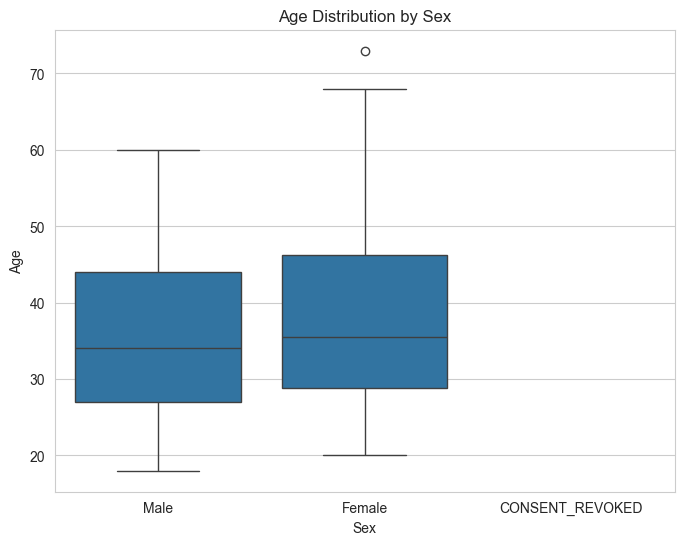

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# 1. Basic Statistics
print("="*50)
print("DEMOGRAPHICS SUMMARY")
print("="*50)
print(f"\nTotal Participants: {len(dm2)}")
print(f"\nAge Statistics:")
print(dm2['Age'].describe())

print(f"\nSex Distribution:")
print(dm2['Sex'].value_counts())
print(f"\n{dm2['Sex'].value_counts(normalize=True)*100}")

print(f"\nTop 10 Nationalities:")
print(dm2['Nationality'].value_counts().head(10))

print(f"\nExperiment Distribution:")
print(dm2['expName'].value_counts())

# for each experiment, print number of participants classified as random
print("\nRandom Choice Classification by Experiment:")
for exp in dm2['expName'].unique():
    pids_exp = dm2[dm2.expName == exp].prolificID.unique()
    n_random = df[(df.prolificID.isin(pids_exp)) & (df.group == 'random')].prolificID.nunique()
    n_total = len(pids_exp)
    print(f"{exp}: {n_random} out of {n_total} participants classified as random ({(n_random/n_total)*100:.2f}%)")  

# 2. Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Age distribution
axes[0, 0].hist(dm2['Age'], bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Age Distribution')
axes[0, 0].axvline(dm2['Age'].mean(), color='red', linestyle='--', label=f'Mean: {dm2["Age"].mean():.1f}')
axes[0, 0].legend()

# Sex distribution
sex_counts = dm2['Sex'].value_counts()
axes[0, 1].bar(sex_counts.index, sex_counts.values, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Sex')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Sex Distribution')
for i, v in enumerate(sex_counts.values):
    axes[0, 1].text(i, v + 0.5, str(v), ha='center', va='bottom')

# Top nationalities
top_nat = dm2['Nationality'].value_counts().head(10)
axes[1, 0].barh(range(len(top_nat)), top_nat.values, edgecolor='black', alpha=0.7)
axes[1, 0].set_yticks(range(len(top_nat)))
axes[1, 0].set_yticklabels(top_nat.index)
axes[1, 0].set_xlabel('Count')
axes[1, 0].set_title('Top 10 Nationalities')
axes[1, 0].invert_yaxis()

# Experiment distribution
exp_counts = dm2['expName'].value_counts()
axes[1, 1].bar(range(len(exp_counts)), exp_counts.values, edgecolor='black', alpha=0.7)
axes[1, 1].set_xticks(range(len(exp_counts)))
axes[1, 1].set_xticklabels(exp_counts.index, rotation=45, ha='right')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Experiment Distribution')
for i, v in enumerate(exp_counts.values):
    axes[1, 1].text(i, v + 0.5, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 3. Age by Sex
print("\n" + "="*50)
print("AGE BY SEX")
print("="*50)
print(dm2.groupby('Sex')['Age'].describe())

# 4. Age by Experiment
print("\n" + "="*50)
print("AGE BY EXPERIMENT")
print("="*50)
print(dm2.groupby('expName')['Age'].describe())

# Optional: Additional boxplot for Age by Sex
plt.figure(figsize=(8, 6))
sns.boxplot(data=dm2, x='Sex', y='Age')
plt.title('Age Distribution by Sex')
plt.ylabel('Age')
plt.show()